## Compare datasets
Compares NASS county totals with values seen in the EWG dataset

In [1]:
import pandas as pd
%matplotlib inline

### DEQ Data (pulled from online)

In [2]:
#Get the DEQ datset (online) and pivot so that animals are all in one column
dfDEQ_raw = pd.read_excel('https://files.nc.gov/ncdeq/List_Permitted_Animal_Facilities2-12-2019.xls',skiprows=2)
dfDEQ = dfDEQ_raw.pivot_table(index='County Name',
                              columns='Regulated Operation',
                              values='Allowable Count',
                              aggfunc = 'sum').fillna(0)
#Combine poultry
dfDEQ['Poultry'] = dfDEQ['Dry Poultry'] + dfDEQ['Wet Poultry']
#Drop unused columns
dfDEQ.drop(['Horses','Other Animals ','Dry Poultry','Wet Poultry'],axis=1,inplace=True)
#Rename columns
dfDEQ.columns = ['DEQ_Cattle','DEQ_Hogs','DEQ_Poultry']

### EWG Data (from local scraped copies)

In [3]:
#Get the EWG Datasets
dfEWG_Poultry = pd.read_csv('../data/raw/ScrapedEWG/EWG_Poultry.csv',usecols=['BIRD_COUNT','COUNTYNAME'])
dfEWG_Swine = pd.read_csv('../data/raw/ScrapedEWG/EWG_Swine.csv',usecols=['ANIMAL_COUNT','COUNTYNAME'])
dfEWG_Cattle = pd.read_csv('../data/raw/ScrapedEWG/EWG_Cattle.csv',usecols=['ANIMAL_COUNT','COUNTYNAME'])

#Pivot each dataset on county
dfEWG_P1 = dfEWG_Poultry.groupby('COUNTYNAME').agg({'BIRD_COUNT':'sum'})
dfEWG_S1 = dfEWG_Swine.groupby('COUNTYNAME').agg({'ANIMAL_COUNT':'sum'})
dfEWG_C1 = dfEWG_Cattle.groupby('COUNTYNAME').agg({'ANIMAL_COUNT':'sum'})

In [4]:
#Merge into one
dfEWG = pd.merge(pd.merge(dfEWG_P1,dfEWG_S1,left_index=True,right_index=True,how='outer'),
                     dfEWG_C1,left_index=True,right_index=True,how='outer')

dfEWG.columns = ['EWG_Poultry','EWG_Hogs','EWG_Cattle']
dfEWG.head()

,EWG_Poultry,EWG_Hogs,EWG_Cattle
COUNTYNAME,,,
Alamance,929430.0,600.0,1590.0
Alexander,3694536.0,NaN,650.0
Alleghany,14239.0,NaN,2117.0
Anson,4284486.0,46158.0,700.0
Ashe,28478.0,NaN,NaN


### NASS data (from local processed copies)

In [5]:
#Get the NASS Datasets
dfNASS_Poultry = pd.read_csv('../data/processed/CHICKENS_2017.csv',
                             usecols=['county_name',
                                      'CHICKENS, BROILERS - INVENTORY',
                                      'CHICKENS, LAYERS - INVENTORY',
                                      'CHICKENS, PULLETS, REPLACEMENT - INVENTORY',
                                      'CHICKENS, ROOSTERS - INVENTORY'],
                             index_col='county_name')
dfNASS_Hogs = pd.read_csv('../data/processed/HOGS_2017.csv',
                          usecols=('county_name','HOGS - INVENTORY'),
                          index_col='county_name')
dfNASS_Cattle = pd.read_csv('../data/processed/CATTLE_2017.csv',
                            usecols=('county_name','CATTLE, INCL CALVES - INVENTORY'),
                            index_col='county_name')

#Sum all poultry columns
dfNASS_Poultry['NASS_Poultry'] = dfNASS_Poultry.sum(axis=1)
dfNASS_Poultry.drop(dfNASS_Poultry.columns[:-1],axis=1,inplace=True)

#Rename the Hog and Cattle fields
dfNASS_Hogs.columns = ['NASS_Hogs']
dfNASS_Cattle.columns = ['NASS_Cattle']

#Merge all tables together
dfNASS = pd.merge(pd.merge(dfNASS_Poultry,dfNASS_Hogs,left_index=True,right_index=True,how='outer'),
                           dfNASS_Cattle,left_index=True,right_index=True,how='outer')

### Merge all the datasets together

In [6]:
#Fix indexes 
dfDEQ.set_index(dfDEQ.index.str.upper(),inplace=True)
dfEWG.set_index(dfEWG.index.str.upper(),inplace=True)

#Merge
dfAll = pd.merge(pd.merge(dfDEQ,dfEWG,left_index=True,right_index=True,how='outer'),
                 dfNASS,left_index=True,right_index=True,how='outer')
dfAll.to_csv('../data/processed/DataComparison.csv',index_label='COUNTY')

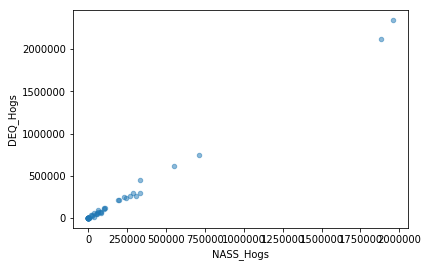

In [7]:
#Plot
ax = dfAll.plot(kind='scatter',
                x='NASS_Hogs',
                y='DEQ_Hogs',
                alpha=0.5)

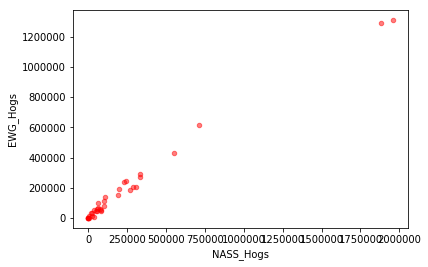

In [8]:
dfAll.plot(kind='scatter',
           x='NASS_Hogs',
           y='EWG_Hogs',
           color='red',
           alpha=0.5);